In [1]:
import scipy
import numpy as np
import casadi as cs
import time
import torch
import gpytorch
import safe_control_gym
import time
import pybullet as p
from functools import partial
from safe_control_gym.utils.registration import make
from safe_control_gym.utils.configuration import ConfigFactory
import yaml
from safe_control_gym.controllers.mpc.mpc_utils import discretize_linear_system
from safe_control_gym.controllers.mpc.gp_utils import GaussianProcessCollection, ZeroMeanIndependentGPModel, covSEard

pybullet build time: Dec  1 2021 18:33:43


In [2]:
from safe_control_gym.controllers.lqr.lqr import LQR
from skopt.sampler import Lhs
seed = 42

In [3]:
CONFIG_FACTORY = ConfigFactory()   

In [4]:
config = CONFIG_FACTORY.merge()

/home/migooll/safe-control-gym/safe_control_gym/utils/configuration.py:72: UserWarning: No agent/task config given.
  warnings.warn("No agent/task config given.")


In [5]:
with open("cartpole.yaml", 'r') as stream:
    try:
        args = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
    
for key in args:
    config[key]=args[key]

In [6]:
config.cartpole_config

{'info_in_reset': True,
 'ctrl_freq': 50,
 'pyb_freq': 50,
 'gui': False,
 'normalized_rl_action_space': False,
 'episode_len_sec': 5,
 'init_state': None,
 'randomized_init': True,
 'init_state_randomization_info': None,
 'inertial_prop': None,
 'randomized_inertial_prop': False,
 'inertial_prop_randomization_info': None,
 'task': 'stabilization',
 'task_info': None,
 'cost': 'rl_reward',
 'disturbances': None,
 'adversary_disturbance': None,
 'adversary_disturbance_offset': 0.0,
 'adversary_disturbance_scale': 0.01,
 'constraints': None,
 'done_on_violation': False,
 'use_constraint_penalty': False,
 'constraint_penalty': -1,
 'verbose': False,
 'obs_wrap_angle': False,
 'rew_state_weight': 1.0,
 'rew_act_weight': 0.0001,
 'rew_exponential': True,
 'done_on_out_of_bound': True}

In [7]:
env_func = partial(make, 'cartpole', **config.cartpole_config)

In [8]:
init_ctrl = make('lqr', env_func, plot_dir = "~/")

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [9]:
env = env_func()

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [10]:
init_ctrl.reset()

In [11]:
init_ctrl.model.df_func()

{'dfdu': DM([00, 0.97561, 00, -1.46341]),
 'dfdx': DM(
 [[00, 1, 00, 00], 
  [00, 00, -0.717073, 0], 
  [00, 00, 00, 1], 
  [00, 00, 15.7756, -0]])}

In [12]:
print(init_ctrl.env.action_space)
print(init_ctrl.env.observation_space)

Box([-10.], [10.], (1,), float32)
Box([-4.8000002e+00 -3.4028235e+38 -3.1415927e+00 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 3.1415927e+00 3.4028235e+38], (4,), float32)


In [13]:
lhs_sampler = Lhs(lhs_type='classic', criterion='maximin')
train_iters = 3
val_iters = 1
limits = [(init_ctrl.env.INIT_STATE_RAND_INFO[key]['low'],init_ctrl.env.INIT_STATE_RAND_INFO[key]['high']) for key in init_ctrl.env.INIT_STATE_RAND_INFO]
samples = lhs_sampler.generate(limits, train_iters+val_iters,
                               random_state=seed)
samples = np.array(samples)

In [14]:
prior_ctrl = LQR(env_func,plot_dir='~/')
prior_ctrl.reset()

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [15]:
def set_dynamics_func(prior_ctrl):
        """Updates symbolic dynamics with actual control frequency.
        """
        # Original version, used in shooting.
        # Prior dynamics taken as f(x,u)=x
        dfdx = np.eye(prior_ctrl.model.nx)
        dfdu = np.zeros((prior_ctrl.model.nx, prior_ctrl.model.nu))
        delta_x = cs.MX.sym('delta_x', prior_ctrl.model.nx,1)
        delta_u = cs.MX.sym('delta_u', prior_ctrl.model.nu,1)
        x_dot_lin_vec = dfdx @ delta_x + dfdu @ delta_u
        prior_ctrl.linear_dynamics_func = cs.integrator(
            'linear_discrete_dynamics', prior_ctrl.model.integration_algo,
            {
                'x': delta_x,
                'p': delta_u,
                'ode': x_dot_lin_vec
            }, {'tf': prior_ctrl.model.dt}
        )
        prior_ctrl.dfdx = dfdx
        prior_ctrl.dfdu = dfdu

set_dynamics_func(prior_ctrl)
prior_dynamics_func = prior_ctrl.linear_dynamics_func
        
def preprocess_training_data(x_seq, u_seq, x_next_seq):
        """Converts trajectory data for GP trianing.
        
        Args:
            x_seq (list): state sequence of np.array (nx,). 
            u_seq (list): action sequence of np.array (nu,). 
            x_next_seq (list): next state sequence of np.array (nx,). 
            
        Returns:
            np.array: inputs for GP training, (N, nx+nu).
            np.array: targets for GP training, (N, nx).
        """
        # Get the predicted dynamics. This is a linear prior, thus we need to account for the fact that
        # it is linearized about an eq using self.X_GOAL and self.U_GOAL.
        x_pred_seq = prior_dynamics_func(x0=x_seq.T - prior_ctrl.env.X_GOAL[:,None],
                                               p=u_seq.T - prior_ctrl.env.U_GOAL[:,None])['xf'].toarray()
        
        targets = (x_next_seq.T - (x_pred_seq+prior_ctrl.env.X_GOAL[:,None])).transpose()  # (N, nx).
        inputs = np.hstack([x_seq, u_seq])  # (N, nx+nu).
        return inputs, targets

In [16]:
train_inputs = []
train_targets = []
for i in range(train_iters+val_iters):
    init_state = samples[i,:]
    run_env = env_func(init_state=init_state, randomized_init=False)
    eval_results = init_ctrl.run(run_env)
    x_obs = eval_results["obs"]
    u_seq = eval_results["action"][:-1,:]
    x_seq = x_obs[:-1,:]
    x_next_seq = x_obs[1:,:]
    run_env.close()
    train_inputs_i, train_targets_i = preprocess_training_data(x_seq, u_seq, x_next_seq)
    train_inputs.append(train_inputs_i)
    train_targets.append(train_targets_i)


@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -0.02 -0.05 0.04 -0.01
Test Run 0 reward 248.78
initial state: -0.02 -0.05 0.04 -0.01
final state: 0.01 -0.01 0.00 -0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): 0.01 -0.02 -0.05 0.04
Test Run 0 reward 247.41
initial state: 0.01 -0.02 -0.05 0.04
final state: -0.01 0.01 -0.00 0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): 0.05 0.00 0.02 -0.04
Test Run 0 reward 249.60
initial sta

In [17]:
from sklearn.model_selection import train_test_split
train_inputs = np.vstack(train_inputs)
train_targets = np.vstack(train_targets)
data_inputs = train_inputs
data_targets = train_targets
train_idx, test_idx = train_test_split(
                                #list(range(self.train_iterations + self.validation_iterations)),
                                list(range(train_inputs.shape[0])),
                                test_size=val_iters/(train_iters+val_iters),
                                random_state=seed
                                )
train_inputs = data_inputs[train_idx, :]
train_targets = data_targets[train_idx, :]
train_data = {'train_inputs': train_inputs, 'train_targets': train_targets}
test_inputs = data_inputs[test_idx, :]
test_targets = data_targets[test_idx, :]
test_data = {'test_inputs': test_inputs, 'test_targets': test_targets}

train_inputs_tensor = torch.Tensor(train_inputs).double()
train_targets_tensor = torch.Tensor(train_targets).double()
test_inputs_tensor = torch.Tensor(test_inputs).double()
test_targets_tensor = torch.Tensor(test_targets).double()

In [18]:
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
validation_results = prior_ctrl.run(valid_env)
valid_env.close()
x_obs = validation_results['obs']
u_seq = validation_results['action'][:-1]
x_seq = x_obs[:-1, :]
x_next_seq = x_obs[1:, :]

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward 180.54
initial state: -1.00 0.00 0.00 0.00
final state: -0.02 0.04 -0.00 0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [19]:
target_mask=np.arange(prior_ctrl.model.nx).tolist()
input_mask = np.arange(prior_ctrl.model.nx + prior_ctrl.model.nu).tolist()

In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.GreaterThan(1e-6),
            ).double()
gaussian_process = GaussianProcessCollection(ZeroMeanIndependentGPModel,
                                                     likelihood,
                                                     len(target_mask),
                                                     input_mask=input_mask,
                                                     target_mask=target_mask,
                                                     normalize=False
                                                     )

In [21]:
with gpytorch.settings.cholesky_jitter(1e-1):
    gaussian_process.train(train_inputs_tensor,
                            train_targets_tensor,
                            test_inputs_tensor,
                            test_targets_tensor,
                            n_train=[500,500,500,500],
                            learning_rate=[0.1,0.1,0.1,0.1],
                            gpu=False,
                            )

#########################################
#      Training GP dimension 0         #
#########################################
Train iterations: 500
Learning Rate:: 0.1
Iter 1/500 - Train Loss: 0.745, Posterior loss on test data: 0.739
Iter 101/500 - Train Loss: -4.264, Posterior loss on test data: -4.273
Iter 201/500 - Train Loss: -5.919, Posterior loss on test data: -5.933
Iter 301/500 - Train Loss: -5.952, Posterior loss on test data: -5.966
Iter 401/500 - Train Loss: -5.960, Posterior loss on test data: -5.974
Training Complete
Lowest epoch: 499
Lowest Loss: tensor(-5.9640, dtype=torch.float64, grad_fn=<NegBackward0>)
#########################################
#      Training GP dimension 1         #
#########################################
Train iterations: 500
Learning Rate:: 0.1
Iter 1/500 - Train Loss: 0.745, Posterior loss on test data: 0.739
Iter 101/500 - Train Loss: -4.264, Posterior loss on test data: -4.275
Iter 201/500 - Train Loss: -5.912, Posterior loss on test data: -5.

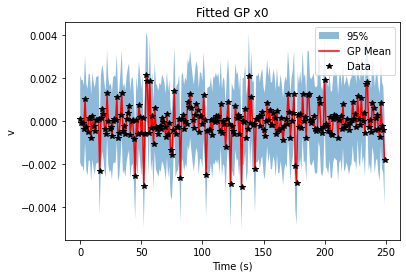

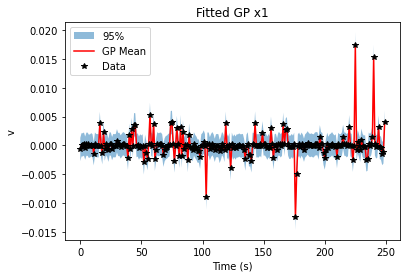

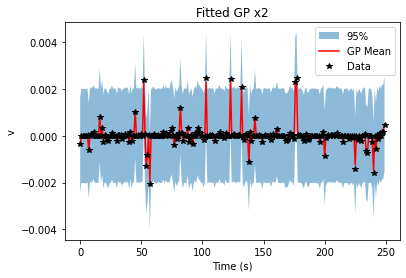

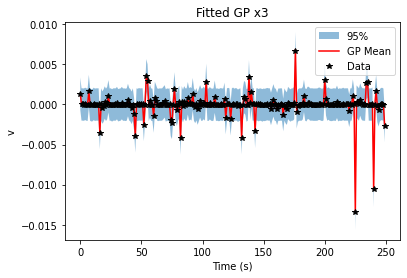

In [22]:
validation_inputs, validation_targets = preprocess_training_data(x_seq, u_seq, x_next_seq)
fig_count = 0
fig_count = gaussian_process.plot_trained_gp(test_inputs_tensor,
                                              test_targets_tensor,
                                              fig_count=fig_count)

In [23]:
gp_hyp = gaussian_process.get_hyperparameters() #lengthscale and outputscale are parameterized on a logscale

In [24]:
lin_query = torch.tensor(np.hstack((prior_ctrl.env.X_GOAL[:,None].T,prior_ctrl.env.U_GOAL[:,None])))

In [25]:
def get_gp_jacob(gp, query):
    jacob = []
    for gp in gp.gp_list:
        jacob.append(gp.prediction_jacobian(query).numpy())
    jacob = np.vstack(jacob)
    return jacob

In [26]:
gp_jacobian = get_gp_jacob(gaussian_process, lin_query)

In [27]:
A = prior_ctrl.dfdx
B = prior_ctrl.dfdu

In [28]:
gp_jacobian[:,-1].shape

(4,)

In [29]:
A_learned = A + gp_jacobian[:,:-1]
B_learned = B + gp_jacobian[:,-1].reshape(-1,1)

In [30]:
P = scipy.linalg.solve_discrete_are(A_learned, B_learned, prior_ctrl.Q, prior_ctrl.R)
btp = np.dot(B_learned.T, P)
post_gain = np.dot(np.linalg.inv(prior_ctrl.R + np.dot(btp, B_learned)),
                               np.dot(btp, A_learned))

In [31]:
init_ctrl.gain

array([[ -0.98009309,  -2.26529958, -31.58676795,  -8.10141038]])

In [32]:
post_gain

array([[ -0.63045689,  -1.60321458, -27.49889462,  -6.98319691]])

In [33]:
prior_ctrl.gain = post_gain

In [34]:
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
post_results = prior_ctrl.run(valid_env)
valid_env.close()

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward 174.72
initial state: -1.00 0.00 0.00 0.00
final state: -0.04 0.06 -0.01 0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[174.71746974]


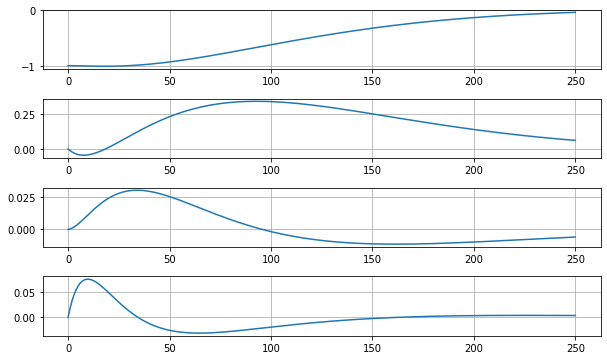

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(prior_ctrl.x_0.shape[0],1, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

print(post_results['ep_returns'])
for d, ax in enumerate(axs.ravel()):
    ax.plot(post_results['obs'][:,d])
    ax.grid(True)


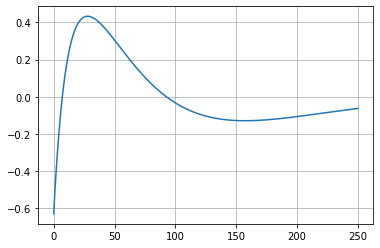

In [36]:
plt.plot(post_results['action'])
plt.grid(1)